### Useful links
- [CampusX - Handwritten Digit Classification using ANN](https://www.youtube.com/watch?v=3xPT2Pk0Jds)
- [Shubham Singh - The EMNIST dataset letter recognition](https://www.youtube.com/watch?v=3xPT2Pk0Jds)
- [Emnist classification](https://github.com/sejalgupta01/EMNIST-Classification/blob/master/EMNIST_Classification%20(3).ipynb)
- [Deep learning-Deep understanding by shubham singh](https://www.youtube.com/playlist?list=PL2FZtB-DAFqk4iXGu1xK1_fUmTCjtfQhV)
- [Neural Network from Scratch | Mathematics & Python Code](https://www.youtube.com/watch?v=pauPCy_s0Ok)
- https://github.com/khelli07/ai-fnn/blob/main/README.md
- https://khelli07.medium.com/introduction-to-artificial-neural-network-in-deep-learning-aa7ba2280f50
- https://khelli07.medium.com/feedforward-neural-network-fnn-implementation-from-scratch-using-python-467f51ecca3d
- https://towardsdatascience.com/creating-neural-networks-from-scratch-in-python-6f02b5dd911
- https://subscription.packtpub.com/book/data/9781789346640/1/ch01lvl1sec05/feed-forward-propagation-from-scratch-in-python
- [Softmax Layer from Scratch ](https://www.youtube.com/watch?v=AbLvJVwySEo)

### Dependencies

In [9]:
# ! pip install torchvision
# ! pip install tqdm
# ! pip install matplotlib
# ! pip install scikit-learn
# ! pip install seaborn

In [10]:
# fix random seed
import numpy as np
np.random.seed(0)
np.random.RandomState(0)

# torch random seed
import torch
torch.manual_seed(0)

import torchvision.datasets as ds
import torchvision.transforms as transforms
from tqdm import tqdm

### Dataset

In [11]:
# Download the training and validation datasets

train_val_ds = ds.EMNIST(
    root="./data",
    split="letters",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)
 

In [12]:

test_ds = ds.EMNIST(
    root="./data",
    split="letters",
    train=False,
    transform=transforms.ToTensor(),
)


### Preprocessing

In [13]:
# get labels
labels = np.array(train_val_ds.targets)
# get unique labels
unique_labels = np.unique(labels)

# print number of samples per class
for label in unique_labels:
    print(f"number of samples for class {label}: {np.sum(labels == label)}")

number of samples for class 1: 4800
number of samples for class 2: 4800
number of samples for class 3: 4800
number of samples for class 4: 4800
number of samples for class 5: 4800
number of samples for class 6: 4800
number of samples for class 7: 4800
number of samples for class 8: 4800
number of samples for class 9: 4800
number of samples for class 10: 4800
number of samples for class 11: 4800
number of samples for class 12: 4800
number of samples for class 13: 4800
number of samples for class 14: 4800
number of samples for class 15: 4800
number of samples for class 16: 4800
number of samples for class 17: 4800
number of samples for class 18: 4800
number of samples for class 19: 4800
number of samples for class 20: 4800
number of samples for class 21: 4800
number of samples for class 22: 4800
number of samples for class 23: 4800
number of samples for class 24: 4800
number of samples for class 25: 4800
number of samples for class 26: 4800


In [14]:
# remove 'N/A' label and decrease all labels by 1
train_val_ds.targets = train_val_ds.targets - 1
test_ds.targets = test_ds.targets - 1

train_val_ds.classes = train_val_ds.classes[1:]
test_ds.classes = test_ds.classes[1:]

#### Data Normalization

In [15]:
# next issue: do we need to normalize the data?
%matplotlib inline
import matplotlib.pyplot as plt

In [16]:
# normalize the data
train_val_ds.data = train_val_ds.data / torch.max(train_val_ds.data)
test_ds.data = test_ds.data / torch.max(test_ds.data)

### Train-validation split
The dataset contains 28x28 images of letters from the Latin alphabet. Split the train-validation dataset as 85%-15% to form your train set and validation set. 

In [17]:
# convert torch to numpy
train_val_ds.data = train_val_ds.data.numpy()
train_val_ds.targets = train_val_ds.targets.numpy()

# convert torch to numpy
test_ds.data = test_ds.data.numpy()
test_ds.targets = test_ds.targets.numpy()

In [18]:
# use sklearn to split train_validation_dataset into train and validation datasets
from sklearn.model_selection import train_test_split

val_per = 0.15 # validation percentage

# split train_validation_dataset into train and validation datasets as 85% and 15% respectively
train_ds, val_ds, train_labels, val_labels = train_test_split(
    train_val_ds.data,
    train_val_ds.targets,
    test_size=val_per,
    random_state=1,
)

### FFN implementation

##### Loss function
As you can see, our example model is currently random. To remedy this, we need a way to
calculate how wrong the neural network is at current predictions and begin adjusting weights
and biases to decrease error over time. Thus, our next step is to quantify how wrong the model is
through what’s defined as a loss function.

In [19]:
# no matter which loss function we’ll use, the overall loss is always a mean value of all sample losses
# common loss functions
class Loss:
    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        # Calculate mean loss
        data_loss = np.mean(sample_losses)
        # Return loss
        return data_loss

##### Activation function

In [20]:
class Activation:
    def forward(self, inputs):
        raise NotImplementedError
    def backward(self, grad_outputs):
        raise NotImplementedError
    

In [21]:
# ReLU activation
class ReLU(Activation):
    def forward(self, inputs):
        self.inputs = inputs
        return np.maximum(0, inputs)
    
    def backward(self, grad_outputs):
        # Since we need to modify original variable,
        # let’s make a copy of values first
        grad_inputs = grad_outputs.copy()

       # print(f"Relu grad_output shape: {grad_outputs.shape}")

        # Zero gradient where input values were negative
        grad_inputs[self.inputs <= 0] = 0

       # print(f"Relu grad_input shape: {grad_inputs.shape}")

        return grad_inputs

In [22]:
class Softmax(Activation):

    def forward(self, inputs):
        # get row max to subtract from each row
        # this is to prevent overflow
        # the max value in each row will be 0
        # the output will be extactly the same
        row_maxs = np.max(inputs, axis=1, keepdims=True)

        # Get unnormalized probabilities
        # exponentiate values
        exp_values = np.exp(inputs - row_maxs)

        # Get normalization bases for each sample
        norm_bases = np.sum(exp_values, axis=1, keepdims=True)

        # Normalize them for each sample
        probabilities = exp_values / norm_bases

        #print(f"softmax forward output shape: {probabilities.shape}")

        self.outputs = probabilities

        return probabilities
    

    # back propagation
    def backward(self, grad_output):
        # return input_grads
       # print(f"softmax-> grad_output shape: {grad_output.shape}")
        grad_input = self.outputs * (grad_output - np.sum(self.outputs * grad_output, axis=-1, keepdims=True))
       # print(f"softmax-> grad_input shape: {grad_input.shape}")
        return grad_input

In [23]:
class Optimizer:
    # Update parameters
    def update_weights(self, weights, grad_weights):
        raise NotImplementedError
    # update bias
    def update_bias(self, bias, grad_bias):
        raise NotImplementedError

##### layer

In [24]:
class Layer:
    def forward(self, inputs):
        raise NotImplementedError
    
    def backward(self, grad_outputs, optimizer=None):
        raise NotImplementedError
    
    def summary(self):
        raise NotImplementedError

In [25]:
class Flatten(Layer):
    def __init__(self):
        self.input_shape = None
    
    def forward(self, inputs):
        # chec if 2D for batch size
        if len(inputs.shape) <= 1:
            raise ValueError(f"Flatten layer input shape must be greater than 1D. Got {inputs.shape}.")

        # save shape for backward pass
        self.input_shape = inputs.shape

        # flatten inputs
        return inputs.reshape(inputs.shape[0], -1)
    
    def backward(self, grad_outputs, optimizer=None):
        # reshape gradient
        return grad_outputs.reshape(self.input_shape)
    
    def summary(self):
        return "Flatten"

In [26]:
# Dense or fully connected layer
class DenseLayer(Layer):
    # Here, we’re setting weights to be random and biases to be 0
    def __init__(self, 
                 n_inputs:int, 
                 n_neurons:int, 
                 activation:Activation,
                 learning_rate:float = 0.001,
                 debug:bool = False,
                 ) -> None:
        # Xavier initialization
        # We divide by n_inputs to reduce the variance of our outputs
        # and make sure that they are all in the same range
        self.weights = np.random.randn(n_inputs, n_neurons) / np.sqrt(n_inputs)

        # print max and min weights
        if debug:
            print(f"weights shape: {self.weights.shape}")
            print(f"weight (min, max) = ({np.min(self.weights)}, {np.max(self.weights)})")
           
        # xaiver initialization
        self.biases = np.zeros((1, n_neurons))

        if debug:
            print(f"baises shape: {self.biases.shape}")
            print(f"bias (min, max) = ({np.min(self.biases)}, {np.max(self.biases)})")
            

        # activation function
        self.activation = activation
        # learning rate
        self.learning_rate = learning_rate

    # Forward pass
    # When we pass data through a model from beginning to end, this is called a forward pass. 
    def forward(self, inputs:np.ndarray):
        # check input shape
        if len(inputs.shape) != 2:
            raise ValueError(f"input shape must be 2D, got {len(inputs.shape)}D")
        
        # save input
        self.inputs = inputs

        # inputs shape: (batch_size, n_inputs)
        # weights shape: (n_inputs, n_neurons)
        # biases shape: (1, n_neurons)
        # output shape: (batch_size, n_neurons) i.e for each sample, we get n_neurons outputs
        out =  np.dot(inputs, self.weights) + self.biases
     
        out = self.activation.forward(out)
        return out
    
    def backward(self, grad_output:np.ndarray, optimizer:Optimizer):
        # activation function derivative
        grad_output = self.activation.backward(grad_output)

      #  print(f"denselayer-> grad_output shape: {grad_output.shape}")

        # Gradients on parameters
        # dE/dW = dE/dY * dY/dW = dE/dY * X.T
        grad_weights = np.dot(self.inputs.T, grad_output)

        # dE/dB = dE/dY * dY/dB = dE/dY * 1
        grad_biases = grad_output.mean(axis=0) * self.inputs.shape[0]

        # Gradient on values
        # dE/dX = dE/dY * dY/dX = W.T * dE/dY
        grad_inputs = np.dot(grad_output, self.weights.T)

    
        self.weights = optimizer.update_weights(self.weights, grad_weights)
        self.biases = optimizer.update_bias(self.biases,grad_biases)

        return grad_inputs
    
    def summary(self):
        activation_name = self.activation.__class__.__name__
        return f"Dense({self.weights.shape[0]}, {self.weights.shape[1]}), activation: {activation_name}"
    

#### Dropout layer

In [27]:
# Dropout
class DropoutLayer:
    # Init
    def __init__(self, dropout_rate=0.3):
        # Store rate, we invert it as for example for dropout
        # of 0.1 we need success rate of 0.9
        self.rate = 1 - dropout_rate

    # Forward pass
    def forward(self, inputs):
        # Generate and save scaled mask
        self.mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate

        # Apply mask to output values
        return inputs * self.mask

    # Backward pass
    def backward(self, grad_output, _):
        # Gradient on values
        return grad_output * self.mask
    
    def summary(self):
        return f"Dropout(rate: {1-self.rate})"

#### Categorical cross entropy derivative

In [28]:
class CategoricalCrossEntropyLoss(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values-only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        
        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        
        return negative_log_likelihoods
    
    def backward(self, y_pred, y_true):
        # Number of samples
        samples = len(y_pred)

        # Number of labels in every sample
        # We’ll use the first sample to count them
        labels = len(y_pred[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        epsilon = 1e-7

        # Calculate gradient
        grad_output = -y_true / (y_pred+epsilon)
        # Normalize gradient
        grad_output = grad_output / samples

        return grad_output

#### Optimizer

In [29]:
# SGD
class SGD(Optimizer):
    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate:float = 1.0) -> None:
        self.learning_rate = learning_rate

    # Update parameters
    def update_weights(self, weights, grad_weights):
        return weights - grad_weights * self.learning_rate
    
    # update bias
    def update_bias(self, bias, grad_bias):
        return bias - grad_bias * self.learning_rate

#### Model

In [30]:
class History:
    def __init__(self) -> None:
        self.loss = []
        self.accuracy = []
        self.val_loss = []
        self.val_accuracy = []
        self.val_f1 = []
    
    def append(self, loss, accuracy, val_loss, val_accuracy, val_f1):
        self.loss.append(loss)
        self.accuracy.append(accuracy)
        self.val_loss.append(val_loss)
        self.val_accuracy.append(val_accuracy)
        self.val_f1.append(val_f1)

In [31]:
class BestModel:
    def __init__(self) -> None:
        self.layers = None
        self.loss = np.inf
        self.accuracy = 0
        self.f1 = 0 

    def update(self, layers, loss, accuracy, f1):
        if f1 > self.f1:
            self.layers = layers.copy()
            self.loss = loss
            self.accuracy = accuracy
            self.f1 = f1

    def _forward(self, inputs):
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs

In [32]:
# import pickle
import pickle
# import sklern for f1 score
from sklearn.metrics import f1_score
# import confusion matrix
from sklearn.metrics import confusion_matrix
# import accuracy score
from sklearn.metrics import accuracy_score

# import seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

class FNN:
    def __init__(self, 
                 loss:Loss, 
                 optimizer:Optimizer, 
                 learning_rate:float = 0.005,
                 layers:list = [],
                 debug:bool = False,
                 ) -> None:
        self.loss = loss
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.debug = debug

        # history
        self.history = History()
        # best model
        self.best_model = BestModel()
        # layers
        self.layers = layers

    def add(self, layer:Layer):
        self.layers.append(layer)

    # add multiple layers
    def add_all(self, layers:list):
        self.layers.extend(layers)

    # summary
    def summary(self):
        print(f"Model summary")
        print(f"==============")
        optimizer = self.optimizer.__class__.__name__
        print(f"Optimizer: {optimizer}")
        loss = self.loss.__class__.__name__
        print(f"Loss: {loss}")
        learning_rate = self.learning_rate
        print(f"Learning rate: {learning_rate}")
        for i, layer in enumerate(self.layers):
            print(f"Layer {i+1}: {layer.summary()}")
        print(f"Output shape: {self.layers[-1].weights.shape[1]}")

    def save(self, path):
        # clear unnecessary data
        for layer in self.layers:
            if hasattr(layer, "inputs"):
                layer.inputs = None
            # mask for dropout
            if hasattr(layer, "mask"):
                layer.mask = None

            # clear layers activations
            if hasattr(layer, "activation"):
                # clear inputs
                if hasattr(layer.activation, "inputs"):
                    layer.activation.inputs = None
                # clear outputs
                if hasattr(layer.activation, "outputs"):
                    layer.activation.outputs = None
                  

        self.best_model = None
        self.history = None

        # save model
        with open(path, "wb") as f:
            pickle.dump(self, f)

    def save_best_model(self, path):
        # clear unnecessary data
        for layer in self.best_model.layers:
            if hasattr(layer, "inputs"):
                layer.inputs = None
            # mask for dropout
            if hasattr(layer, "mask"):
                layer.mask = None

            # clear layers activations
            if hasattr(layer, "activation"):
                # clear inputs
                if hasattr(layer.activation, "inputs"):
                    layer.activation.inputs = None
                # clear outputs
                if hasattr(layer.activation, "outputs"):
                    layer.activation.outputs = None
                  

        # save best model
        with open(path, "wb") as f:
            pickle.dump(self.best_model, f)

    # load best model
    def load_best_model(self, path):
        # load model
        with open(path, "rb") as f:
            self.best_model = pickle.load(f)

    @staticmethod
    def load(path):
        # load model
        with open(path, "rb") as f:
            return pickle.load(f)

    def _forward(self, X):
        # Forward propagation
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def _backward(self, grad_output):
        # Back propagation
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output, self.optimizer)
        return grad_output

    def _calculate_accuracy(self, y_pred, y_true):
        # Calculate an accuracy
        y_pred_labels = np.argmax(y_pred, axis=1)
        return accuracy_score(y_true, y_pred_labels)
    

    def evaluate(self, X_val, y_val):
        # Calculate an accuracy
        y_pred = self._forward(X_val)
        loss = self.loss.calculate(y_pred, y_val)
        accuracy = self._calculate_accuracy(y_pred, y_val)
        f1 = f1_score(y_val, np.argmax(y_pred, axis=1), average="macro")
        return loss, accuracy, f1
    
    def predict(self, X):
        # Calculate an accuracy
        y_pred = self._forward(X)
        return y_pred

    def best_model_predict(self, X):
        # Calculate an accuracy
        y_pred = self.best_model._forward(X)
        return y_pred
    
    def best_model_evaluate(self, X_val, y_val):
        # Calculate an accuracy
        y_pred = self.best_model._forward(X_val)
        loss = self.loss.calculate(y_pred, y_val)
        accuracy = self._calculate_accuracy(y_pred, y_val)
        f1 = f1_score(y_val, np.argmax(y_pred, axis=1), average="macro")
        return loss, accuracy, f1
    
    
    def shuffle(self, X, y):
        # X and y has different shape
        # so we need to shuffle them together
        # create random index
        random_index = np.random.permutation(len(X))
        # shuffle X and y
        return X[random_index], y[random_index]
    
    
    def fit(self, X, y, X_val, y_val, epochs:int = 5, batch_size:int = 32, best_name="best_model.pkl"):
        # initialize history
        self.history = History()
        # initialize best model
        self.best_model = BestModel()

        # iterate over epochs
        # use tqdm to show progress bar
      
        for epoch in range(epochs):
            # shuffle X and y
            X, y = self.shuffle(X, y)

            epoch_loss = 0
            epoch_accuracy = 0

            # calculate number of batches
            batches = len(X) // batch_size
            if len(X) % batch_size != 0:
                batches += 1

            with tqdm(total=batches, desc="Training", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
                # iterate over batches
                for batch in range(batches):
                    # get batch start and end index
                    X_batch = X[batch*batch_size:(batch+1)*batch_size]
                    y_batch = y[batch*batch_size:(batch+1)*batch_size]

                    # forward propagation
                    y_pred = self._forward(X_batch)
                    # calculate loss
                    epoch_loss += self.loss.calculate(y_pred, y_batch)
                    # calculate accuracy
                    epoch_accuracy += self._calculate_accuracy(y_pred, y_batch)

                    # backward propagation
                    grad_output = self.loss.backward(y_pred, y_batch)
                    self._backward(grad_output)

                    pbar.update(1)

    
            loss  = epoch_loss / batches    
            accuracy = epoch_accuracy / batches

            # evaluate model on validation data
            val_loss, val_accuracy, val_f1 = self.evaluate(X_val, y_val)
            # update history
            self.history.append(loss, accuracy, val_loss, val_accuracy, val_f1)
            # update best model
            self.best_model.update(self.layers, val_loss, val_accuracy, val_f1)

            # update progress bar
            epoch_msg = f"epoch: {epoch+1}/{epochs}, loss: {loss:.4f}, accuracy: {accuracy:.4f}, val_loss: {val_loss:.4f}, val_accuracy: {val_accuracy:.4f}, val_f1: {val_f1:.4f}"
           
            print(epoch_msg)
        
        # save best model
        self.save_best_model(best_name)
                

    def plot(self):
        # plot loss
        plt.plot(self.history.loss, label="loss")
        plt.plot(self.history.val_loss, label="val_loss")
        plt.legend()
        plt.show()

        # plot accuracy
        plt.plot(self.history.accuracy, label="accuracy")
        plt.plot(self.history.val_accuracy, label="val_accuracy")
        plt.legend()
        plt.show()

        # plot f1
        plt.plot(self.history.val_f1, label="val_f1")
        plt.legend()
        plt.show()

    def plot_confusion_matrix(self, X, y):
        # get predictions
        if self.best_model.layers is not None:
            y_pred = self.best_model_predict(X)
        else:
            y_pred = self.predict(X)
        # get labels
        y_pred_labels = np.argmax(y_pred, axis=1)

        # get confusion matrix
        cm = confusion_matrix(y, y_pred_labels)

        # plot confusion matrix
        plt.figure(figsize=(10, 10))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()


### Training

##### Building the model

In [33]:
print(train_ds.shape)
input_shape = train_ds.shape[1:]
input_size = np.prod(input_shape)
print(f"input shape: {input_shape}")
print(f"input size: {input_size}")

(106080, 28, 28)
input shape: (28, 28)
input size: 784


In [34]:
output_size = len(np.unique(train_labels))
print(f"output size: {output_size}")

output size: 26


learning rate: 0.005


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 1/50, loss: 2.7455, accuracy: 0.2497, val_loss: 1.9942, val_accuracy: 0.4265, val_f1: 0.4073


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 2/50, loss: 1.6548, accuracy: 0.5122, val_loss: 1.4706, val_accuracy: 0.5636, val_f1: 0.5542


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 3/50, loss: 1.3470, accuracy: 0.5972, val_loss: 1.2740, val_accuracy: 0.6214, val_f1: 0.6169


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 4/50, loss: 1.1790, accuracy: 0.6460, val_loss: 1.1391, val_accuracy: 0.6621, val_f1: 0.6593


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 5/50, loss: 1.0615, accuracy: 0.6801, val_loss: 1.0299, val_accuracy: 0.6913, val_f1: 0.6889


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 6/50, loss: 0.9692, accuracy: 0.7090, val_loss: 0.9438, val_accuracy: 0.7143, val_f1: 0.7125


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 7/50, loss: 0.8908, accuracy: 0.7299, val_loss: 0.8766, val_accuracy: 0.7376, val_f1: 0.7361


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 8/50, loss: 0.8239, accuracy: 0.7499, val_loss: 0.8247, val_accuracy: 0.7522, val_f1: 0.7510


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 9/50, loss: 0.7730, accuracy: 0.7658, val_loss: 0.7772, val_accuracy: 0.7626, val_f1: 0.7614


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 10/50, loss: 0.7287, accuracy: 0.7782, val_loss: 0.7398, val_accuracy: 0.7759, val_f1: 0.7748


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 11/50, loss: 0.6895, accuracy: 0.7909, val_loss: 0.7053, val_accuracy: 0.7832, val_f1: 0.7827


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 12/50, loss: 0.6572, accuracy: 0.7987, val_loss: 0.6727, val_accuracy: 0.7938, val_f1: 0.7933


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 13/50, loss: 0.6272, accuracy: 0.8084, val_loss: 0.6480, val_accuracy: 0.8022, val_f1: 0.8015


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 14/50, loss: 0.6037, accuracy: 0.8144, val_loss: 0.6209, val_accuracy: 0.8137, val_f1: 0.8134


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 15/50, loss: 0.5836, accuracy: 0.8205, val_loss: 0.6053, val_accuracy: 0.8138, val_f1: 0.8137


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 16/50, loss: 0.5630, accuracy: 0.8254, val_loss: 0.5856, val_accuracy: 0.8216, val_f1: 0.8214


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 17/50, loss: 0.5463, accuracy: 0.8313, val_loss: 0.5708, val_accuracy: 0.8255, val_f1: 0.8248


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 18/50, loss: 0.5290, accuracy: 0.8359, val_loss: 0.5586, val_accuracy: 0.8271, val_f1: 0.8267


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 19/50, loss: 0.5127, accuracy: 0.8416, val_loss: 0.5485, val_accuracy: 0.8317, val_f1: 0.8316


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 20/50, loss: 0.4991, accuracy: 0.8447, val_loss: 0.5324, val_accuracy: 0.8358, val_f1: 0.8357


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 21/50, loss: 0.4883, accuracy: 0.8478, val_loss: 0.5309, val_accuracy: 0.8376, val_f1: 0.8375


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 22/50, loss: 0.4749, accuracy: 0.8510, val_loss: 0.5140, val_accuracy: 0.8404, val_f1: 0.8403


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 23/50, loss: 0.4656, accuracy: 0.8545, val_loss: 0.5069, val_accuracy: 0.8427, val_f1: 0.8426


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 24/50, loss: 0.4558, accuracy: 0.8577, val_loss: 0.4966, val_accuracy: 0.8450, val_f1: 0.8449


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 25/50, loss: 0.4451, accuracy: 0.8608, val_loss: 0.4882, val_accuracy: 0.8498, val_f1: 0.8496


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 26/50, loss: 0.4375, accuracy: 0.8618, val_loss: 0.4761, val_accuracy: 0.8522, val_f1: 0.8519


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 27/50, loss: 0.4289, accuracy: 0.8663, val_loss: 0.4722, val_accuracy: 0.8514, val_f1: 0.8512


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 28/50, loss: 0.4197, accuracy: 0.8674, val_loss: 0.4715, val_accuracy: 0.8521, val_f1: 0.8519


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 29/50, loss: 0.4133, accuracy: 0.8694, val_loss: 0.4573, val_accuracy: 0.8561, val_f1: 0.8559


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 30/50, loss: 0.4063, accuracy: 0.8708, val_loss: 0.4589, val_accuracy: 0.8546, val_f1: 0.8546


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 31/50, loss: 0.4026, accuracy: 0.8722, val_loss: 0.4515, val_accuracy: 0.8608, val_f1: 0.8607


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 32/50, loss: 0.3945, accuracy: 0.8752, val_loss: 0.4431, val_accuracy: 0.8613, val_f1: 0.8613


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 33/50, loss: 0.3864, accuracy: 0.8771, val_loss: 0.4345, val_accuracy: 0.8632, val_f1: 0.8632


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 34/50, loss: 0.3815, accuracy: 0.8779, val_loss: 0.4351, val_accuracy: 0.8635, val_f1: 0.8635


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 35/50, loss: 0.3751, accuracy: 0.8807, val_loss: 0.4272, val_accuracy: 0.8647, val_f1: 0.8646


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 36/50, loss: 0.3704, accuracy: 0.8821, val_loss: 0.4277, val_accuracy: 0.8647, val_f1: 0.8644


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 37/50, loss: 0.3654, accuracy: 0.8839, val_loss: 0.4249, val_accuracy: 0.8671, val_f1: 0.8669


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 38/50, loss: 0.3604, accuracy: 0.8848, val_loss: 0.4202, val_accuracy: 0.8700, val_f1: 0.8698


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 39/50, loss: 0.3548, accuracy: 0.8872, val_loss: 0.4148, val_accuracy: 0.8694, val_f1: 0.8693


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 40/50, loss: 0.3495, accuracy: 0.8877, val_loss: 0.4086, val_accuracy: 0.8701, val_f1: 0.8700


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 41/50, loss: 0.3479, accuracy: 0.8877, val_loss: 0.4115, val_accuracy: 0.8732, val_f1: 0.8732


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 42/50, loss: 0.3419, accuracy: 0.8897, val_loss: 0.4013, val_accuracy: 0.8736, val_f1: 0.8734


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 43/50, loss: 0.3371, accuracy: 0.8916, val_loss: 0.4021, val_accuracy: 0.8717, val_f1: 0.8715


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 44/50, loss: 0.3355, accuracy: 0.8921, val_loss: 0.4023, val_accuracy: 0.8739, val_f1: 0.8737


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 45/50, loss: 0.3305, accuracy: 0.8926, val_loss: 0.3970, val_accuracy: 0.8749, val_f1: 0.8748


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 46/50, loss: 0.3296, accuracy: 0.8940, val_loss: 0.3917, val_accuracy: 0.8769, val_f1: 0.8768


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 47/50, loss: 0.3226, accuracy: 0.8966, val_loss: 0.3924, val_accuracy: 0.8780, val_f1: 0.8779


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 48/50, loss: 0.3176, accuracy: 0.8971, val_loss: 0.3823, val_accuracy: 0.8786, val_f1: 0.8786


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 49/50, loss: 0.3153, accuracy: 0.8971, val_loss: 0.3824, val_accuracy: 0.8798, val_f1: 0.8796


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 50/50, loss: 0.3145, accuracy: 0.8972, val_loss: 0.3797, val_accuracy: 0.8794, val_f1: 0.8792


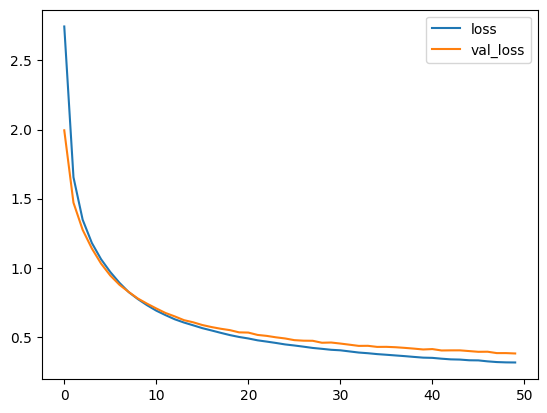

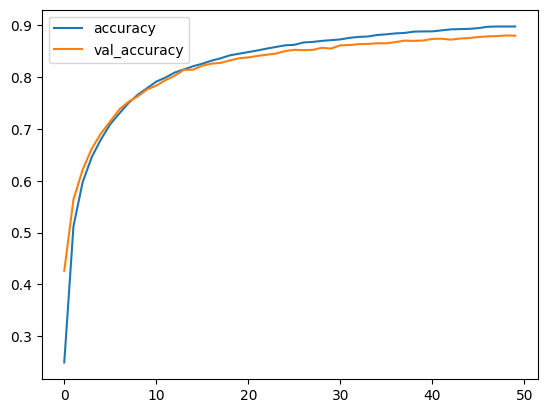

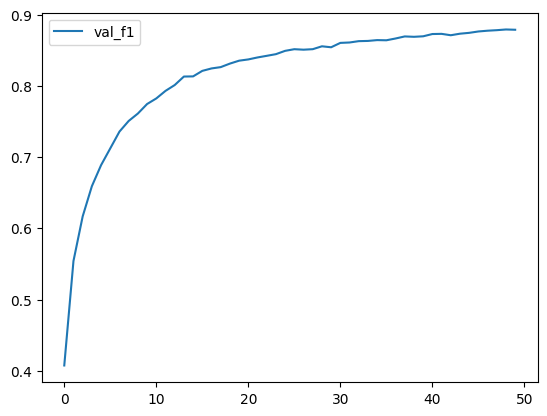

test loss: 0.38683006746952586, test accuracy: 0.8788461538461538, f1: 0.8787307531674016
best test loss: 0.3740598363955921, test accuracy: 0.881201923076923, test f1: 0.8810479945586394


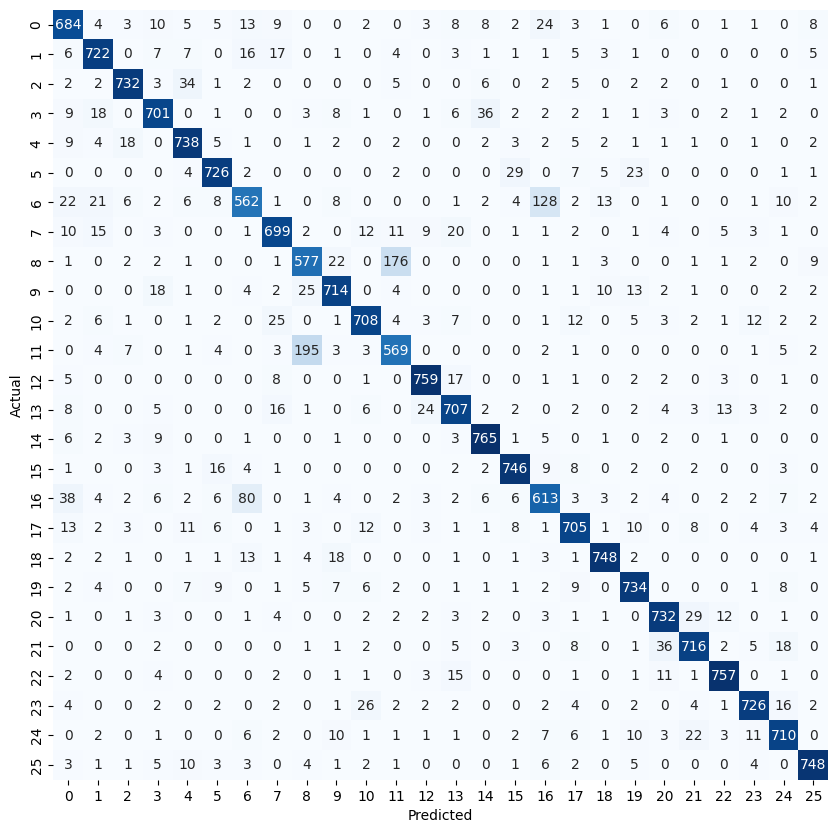

learning rate: 0.0025


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 1/50, loss: 3.0624, accuracy: 0.1530, val_loss: 2.7339, val_accuracy: 0.2672, val_f1: 0.2304


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 2/50, loss: 2.2885, accuracy: 0.3646, val_loss: 1.9574, val_accuracy: 0.4388, val_f1: 0.4251


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 3/50, loss: 1.7575, accuracy: 0.4856, val_loss: 1.6192, val_accuracy: 0.5230, val_f1: 0.5128


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 4/50, loss: 1.5217, accuracy: 0.5484, val_loss: 1.4549, val_accuracy: 0.5675, val_f1: 0.5615


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 5/50, loss: 1.3838, accuracy: 0.5872, val_loss: 1.3483, val_accuracy: 0.5991, val_f1: 0.5956


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 6/50, loss: 1.2818, accuracy: 0.6177, val_loss: 1.2556, val_accuracy: 0.6265, val_f1: 0.6230


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 7/50, loss: 1.2016, accuracy: 0.6405, val_loss: 1.1811, val_accuracy: 0.6516, val_f1: 0.6478


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 8/50, loss: 1.1318, accuracy: 0.6618, val_loss: 1.1161, val_accuracy: 0.6647, val_f1: 0.6623


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 9/50, loss: 1.0679, accuracy: 0.6790, val_loss: 1.0588, val_accuracy: 0.6857, val_f1: 0.6834


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 10/50, loss: 1.0158, accuracy: 0.6949, val_loss: 1.0073, val_accuracy: 0.6952, val_f1: 0.6927


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 11/50, loss: 0.9677, accuracy: 0.7091, val_loss: 0.9633, val_accuracy: 0.7096, val_f1: 0.7076


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 12/50, loss: 0.9254, accuracy: 0.7191, val_loss: 0.9246, val_accuracy: 0.7214, val_f1: 0.7195


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 13/50, loss: 0.8841, accuracy: 0.7339, val_loss: 0.8932, val_accuracy: 0.7301, val_f1: 0.7286


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 14/50, loss: 0.8512, accuracy: 0.7421, val_loss: 0.8606, val_accuracy: 0.7415, val_f1: 0.7404


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 15/50, loss: 0.8207, accuracy: 0.7505, val_loss: 0.8245, val_accuracy: 0.7538, val_f1: 0.7529


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 16/50, loss: 0.7904, accuracy: 0.7597, val_loss: 0.8025, val_accuracy: 0.7556, val_f1: 0.7537


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 17/50, loss: 0.7656, accuracy: 0.7663, val_loss: 0.7836, val_accuracy: 0.7628, val_f1: 0.7616


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 18/50, loss: 0.7424, accuracy: 0.7744, val_loss: 0.7571, val_accuracy: 0.7705, val_f1: 0.7698


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 19/50, loss: 0.7184, accuracy: 0.7813, val_loss: 0.7379, val_accuracy: 0.7748, val_f1: 0.7739


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 20/50, loss: 0.7025, accuracy: 0.7868, val_loss: 0.7193, val_accuracy: 0.7832, val_f1: 0.7824


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 21/50, loss: 0.6818, accuracy: 0.7916, val_loss: 0.7026, val_accuracy: 0.7841, val_f1: 0.7833


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 22/50, loss: 0.6657, accuracy: 0.7971, val_loss: 0.6874, val_accuracy: 0.7926, val_f1: 0.7918


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 23/50, loss: 0.6493, accuracy: 0.8020, val_loss: 0.6735, val_accuracy: 0.7954, val_f1: 0.7949


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 24/50, loss: 0.6343, accuracy: 0.8052, val_loss: 0.6575, val_accuracy: 0.8001, val_f1: 0.7990


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 25/50, loss: 0.6213, accuracy: 0.8101, val_loss: 0.6446, val_accuracy: 0.8041, val_f1: 0.8038


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 26/50, loss: 0.6082, accuracy: 0.8137, val_loss: 0.6347, val_accuracy: 0.8066, val_f1: 0.8060


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 27/50, loss: 0.5979, accuracy: 0.8170, val_loss: 0.6302, val_accuracy: 0.8045, val_f1: 0.8038


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 28/50, loss: 0.5852, accuracy: 0.8200, val_loss: 0.6193, val_accuracy: 0.8119, val_f1: 0.8113


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 29/50, loss: 0.5754, accuracy: 0.8227, val_loss: 0.6025, val_accuracy: 0.8164, val_f1: 0.8158


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 30/50, loss: 0.5639, accuracy: 0.8254, val_loss: 0.5939, val_accuracy: 0.8167, val_f1: 0.8161


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 31/50, loss: 0.5531, accuracy: 0.8289, val_loss: 0.5839, val_accuracy: 0.8206, val_f1: 0.8200


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 32/50, loss: 0.5461, accuracy: 0.8325, val_loss: 0.5820, val_accuracy: 0.8215, val_f1: 0.8212


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 33/50, loss: 0.5364, accuracy: 0.8347, val_loss: 0.5727, val_accuracy: 0.8271, val_f1: 0.8270


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 34/50, loss: 0.5291, accuracy: 0.8357, val_loss: 0.5674, val_accuracy: 0.8286, val_f1: 0.8284


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 35/50, loss: 0.5226, accuracy: 0.8383, val_loss: 0.5549, val_accuracy: 0.8296, val_f1: 0.8294


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 36/50, loss: 0.5146, accuracy: 0.8419, val_loss: 0.5474, val_accuracy: 0.8358, val_f1: 0.8355


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 37/50, loss: 0.5062, accuracy: 0.8434, val_loss: 0.5431, val_accuracy: 0.8329, val_f1: 0.8327


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 38/50, loss: 0.5007, accuracy: 0.8441, val_loss: 0.5394, val_accuracy: 0.8345, val_f1: 0.8344


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 39/50, loss: 0.4958, accuracy: 0.8465, val_loss: 0.5238, val_accuracy: 0.8411, val_f1: 0.8407


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 40/50, loss: 0.4871, accuracy: 0.8481, val_loss: 0.5265, val_accuracy: 0.8399, val_f1: 0.8395


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 41/50, loss: 0.4798, accuracy: 0.8511, val_loss: 0.5202, val_accuracy: 0.8382, val_f1: 0.8380


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 42/50, loss: 0.4764, accuracy: 0.8514, val_loss: 0.5167, val_accuracy: 0.8409, val_f1: 0.8404


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 43/50, loss: 0.4713, accuracy: 0.8521, val_loss: 0.5110, val_accuracy: 0.8432, val_f1: 0.8430


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 44/50, loss: 0.4642, accuracy: 0.8550, val_loss: 0.5035, val_accuracy: 0.8437, val_f1: 0.8434


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 45/50, loss: 0.4588, accuracy: 0.8573, val_loss: 0.5073, val_accuracy: 0.8432, val_f1: 0.8430


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 46/50, loss: 0.4538, accuracy: 0.8579, val_loss: 0.5004, val_accuracy: 0.8422, val_f1: 0.8419


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 47/50, loss: 0.4471, accuracy: 0.8611, val_loss: 0.4893, val_accuracy: 0.8455, val_f1: 0.8450


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 48/50, loss: 0.4445, accuracy: 0.8607, val_loss: 0.4900, val_accuracy: 0.8493, val_f1: 0.8490


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 49/50, loss: 0.4414, accuracy: 0.8615, val_loss: 0.4813, val_accuracy: 0.8556, val_f1: 0.8554


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 50/50, loss: 0.4358, accuracy: 0.8636, val_loss: 0.4791, val_accuracy: 0.8559, val_f1: 0.8557


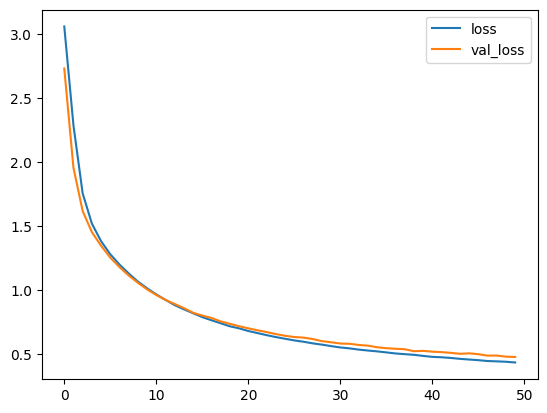

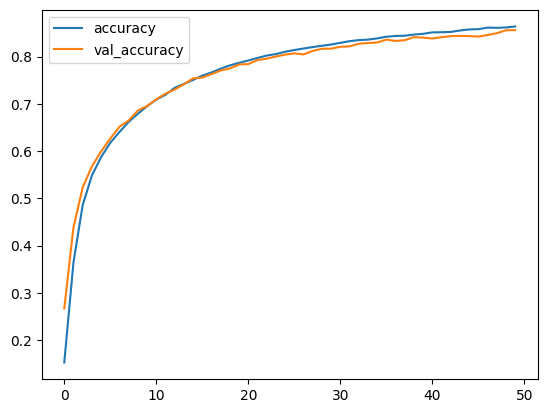

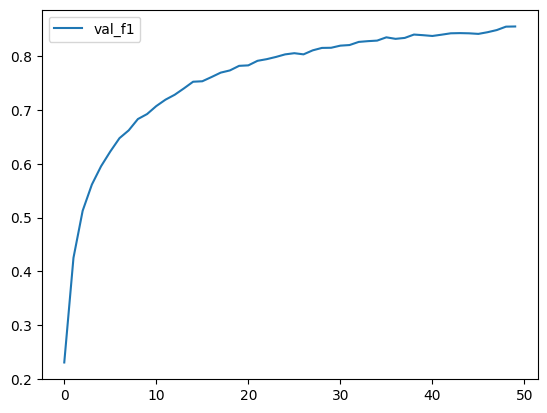

test loss: 0.47784863285848805, test accuracy: 0.853125, f1: 0.852846903751188
best test loss: 0.4787475552579321, test accuracy: 0.8514903846153846, test f1: 0.8512685049100903


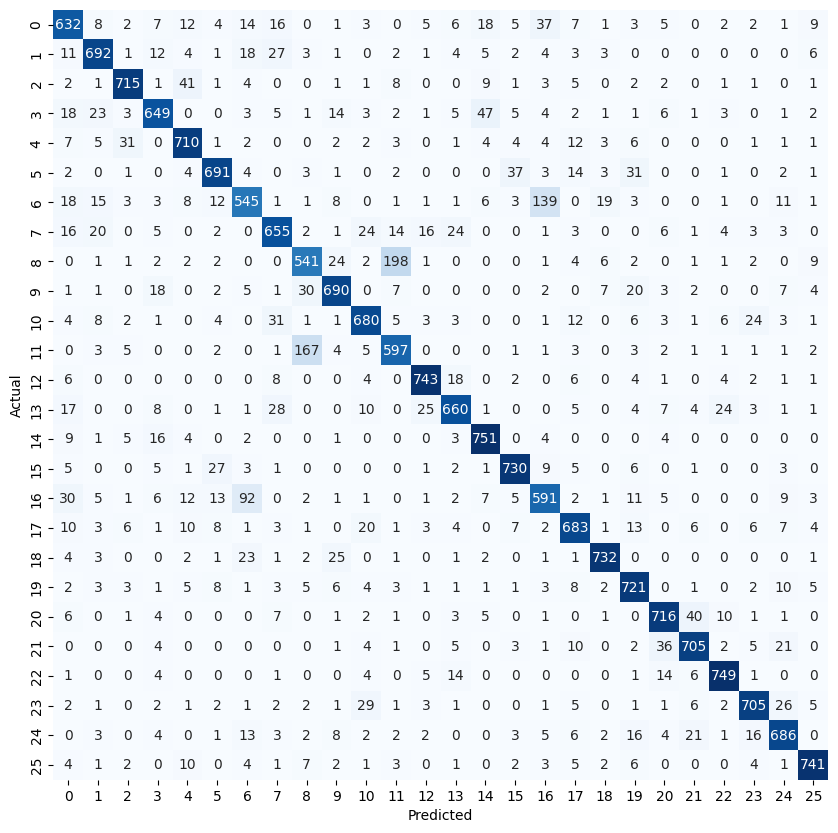

learning rate: 0.001


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 1/50, loss: 3.2270, accuracy: 0.0626, val_loss: 3.1741, val_accuracy: 0.1023, val_f1: 0.0894


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 2/50, loss: 3.0946, accuracy: 0.1514, val_loss: 2.9920, val_accuracy: 0.2040, val_f1: 0.1770


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 3/50, loss: 2.8395, accuracy: 0.2493, val_loss: 2.6614, val_accuracy: 0.3008, val_f1: 0.2723


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 4/50, loss: 2.4572, accuracy: 0.3447, val_loss: 2.2743, val_accuracy: 0.3785, val_f1: 0.3544


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 5/50, loss: 2.1085, accuracy: 0.4104, val_loss: 1.9872, val_accuracy: 0.4330, val_f1: 0.4173


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 6/50, loss: 1.8757, accuracy: 0.4579, val_loss: 1.7987, val_accuracy: 0.4771, val_f1: 0.4675


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 7/50, loss: 1.7245, accuracy: 0.4938, val_loss: 1.6806, val_accuracy: 0.5106, val_f1: 0.5012


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 8/50, loss: 1.6143, accuracy: 0.5226, val_loss: 1.5870, val_accuracy: 0.5308, val_f1: 0.5234


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 9/50, loss: 1.5321, accuracy: 0.5461, val_loss: 1.5095, val_accuracy: 0.5501, val_f1: 0.5437


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 10/50, loss: 1.4666, accuracy: 0.5641, val_loss: 1.4500, val_accuracy: 0.5721, val_f1: 0.5671


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 11/50, loss: 1.4080, accuracy: 0.5815, val_loss: 1.4011, val_accuracy: 0.5860, val_f1: 0.5820


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 12/50, loss: 1.3667, accuracy: 0.5924, val_loss: 1.3645, val_accuracy: 0.5985, val_f1: 0.5951


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 13/50, loss: 1.3231, accuracy: 0.6057, val_loss: 1.3158, val_accuracy: 0.6097, val_f1: 0.6056


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 14/50, loss: 1.2840, accuracy: 0.6168, val_loss: 1.2832, val_accuracy: 0.6186, val_f1: 0.6156


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 15/50, loss: 1.2505, accuracy: 0.6288, val_loss: 1.2456, val_accuracy: 0.6287, val_f1: 0.6255


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 16/50, loss: 1.2209, accuracy: 0.6355, val_loss: 1.2235, val_accuracy: 0.6341, val_f1: 0.6317


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 17/50, loss: 1.1909, accuracy: 0.6468, val_loss: 1.1921, val_accuracy: 0.6438, val_f1: 0.6404


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 18/50, loss: 1.1644, accuracy: 0.6527, val_loss: 1.1696, val_accuracy: 0.6494, val_f1: 0.6470


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 19/50, loss: 1.1378, accuracy: 0.6597, val_loss: 1.1376, val_accuracy: 0.6671, val_f1: 0.6645


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 20/50, loss: 1.1110, accuracy: 0.6698, val_loss: 1.1193, val_accuracy: 0.6675, val_f1: 0.6654


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 21/50, loss: 1.0873, accuracy: 0.6744, val_loss: 1.0958, val_accuracy: 0.6726, val_f1: 0.6701


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 22/50, loss: 1.0628, accuracy: 0.6831, val_loss: 1.0766, val_accuracy: 0.6816, val_f1: 0.6799


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 23/50, loss: 1.0419, accuracy: 0.6875, val_loss: 1.0581, val_accuracy: 0.6855, val_f1: 0.6838


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 24/50, loss: 1.0249, accuracy: 0.6920, val_loss: 1.0293, val_accuracy: 0.6913, val_f1: 0.6893


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 25/50, loss: 1.0037, accuracy: 0.6991, val_loss: 1.0152, val_accuracy: 0.6970, val_f1: 0.6951


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 26/50, loss: 0.9863, accuracy: 0.7047, val_loss: 1.0038, val_accuracy: 0.6995, val_f1: 0.6977


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 27/50, loss: 0.9696, accuracy: 0.7077, val_loss: 0.9816, val_accuracy: 0.7083, val_f1: 0.7064


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 28/50, loss: 0.9518, accuracy: 0.7137, val_loss: 0.9608, val_accuracy: 0.7138, val_f1: 0.7122


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 29/50, loss: 0.9331, accuracy: 0.7189, val_loss: 0.9534, val_accuracy: 0.7179, val_f1: 0.7167


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 30/50, loss: 0.9172, accuracy: 0.7244, val_loss: 0.9295, val_accuracy: 0.7199, val_f1: 0.7183


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 31/50, loss: 0.9030, accuracy: 0.7277, val_loss: 0.9195, val_accuracy: 0.7271, val_f1: 0.7262


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 32/50, loss: 0.8859, accuracy: 0.7337, val_loss: 0.9099, val_accuracy: 0.7263, val_f1: 0.7252


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 33/50, loss: 0.8769, accuracy: 0.7366, val_loss: 0.8918, val_accuracy: 0.7337, val_f1: 0.7323


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 34/50, loss: 0.8622, accuracy: 0.7405, val_loss: 0.8795, val_accuracy: 0.7372, val_f1: 0.7361


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 35/50, loss: 0.8497, accuracy: 0.7435, val_loss: 0.8685, val_accuracy: 0.7380, val_f1: 0.7371


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 36/50, loss: 0.8377, accuracy: 0.7462, val_loss: 0.8558, val_accuracy: 0.7413, val_f1: 0.7404


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 37/50, loss: 0.8251, accuracy: 0.7507, val_loss: 0.8432, val_accuracy: 0.7465, val_f1: 0.7455


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 38/50, loss: 0.8128, accuracy: 0.7549, val_loss: 0.8331, val_accuracy: 0.7491, val_f1: 0.7481


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 39/50, loss: 0.8039, accuracy: 0.7569, val_loss: 0.8264, val_accuracy: 0.7476, val_f1: 0.7467


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 40/50, loss: 0.7914, accuracy: 0.7601, val_loss: 0.8110, val_accuracy: 0.7549, val_f1: 0.7539


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 41/50, loss: 0.7812, accuracy: 0.7630, val_loss: 0.8082, val_accuracy: 0.7564, val_f1: 0.7556


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 42/50, loss: 0.7721, accuracy: 0.7662, val_loss: 0.8036, val_accuracy: 0.7581, val_f1: 0.7572


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 43/50, loss: 0.7645, accuracy: 0.7688, val_loss: 0.7866, val_accuracy: 0.7663, val_f1: 0.7655


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 44/50, loss: 0.7540, accuracy: 0.7722, val_loss: 0.7784, val_accuracy: 0.7614, val_f1: 0.7605


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 45/50, loss: 0.7424, accuracy: 0.7744, val_loss: 0.7639, val_accuracy: 0.7700, val_f1: 0.7693


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 46/50, loss: 0.7353, accuracy: 0.7763, val_loss: 0.7522, val_accuracy: 0.7761, val_f1: 0.7751


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 47/50, loss: 0.7264, accuracy: 0.7788, val_loss: 0.7516, val_accuracy: 0.7724, val_f1: 0.7718


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 48/50, loss: 0.7199, accuracy: 0.7806, val_loss: 0.7443, val_accuracy: 0.7725, val_f1: 0.7717


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 49/50, loss: 0.7122, accuracy: 0.7826, val_loss: 0.7386, val_accuracy: 0.7757, val_f1: 0.7749


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 50/50, loss: 0.7001, accuracy: 0.7871, val_loss: 0.7308, val_accuracy: 0.7805, val_f1: 0.7799


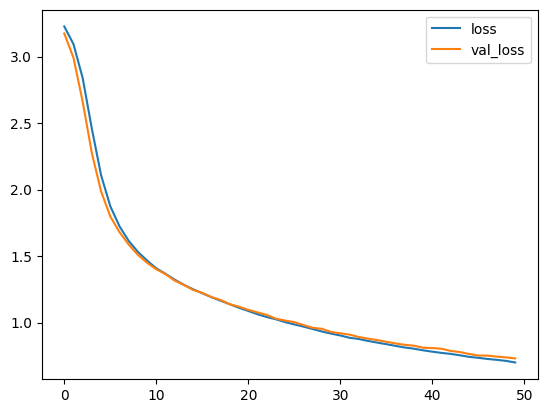

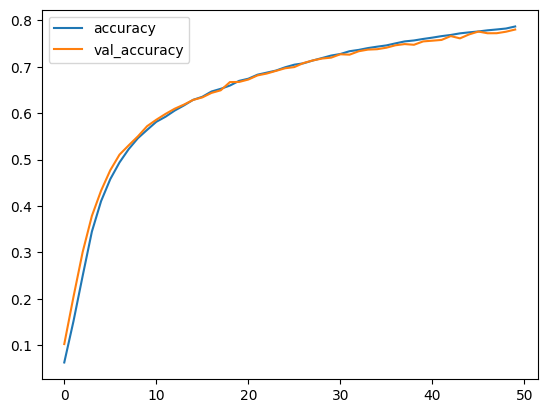

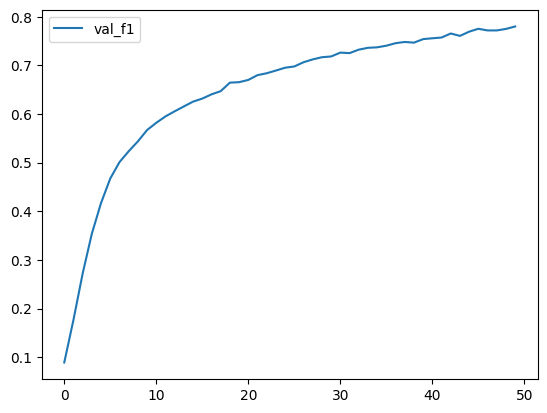

test loss: 0.7198526507058407, test accuracy: 0.781826923076923, f1: 0.7808631129755254
best test loss: 0.723144904547535, test accuracy: 0.7813942307692308, test f1: 0.7805492979592032


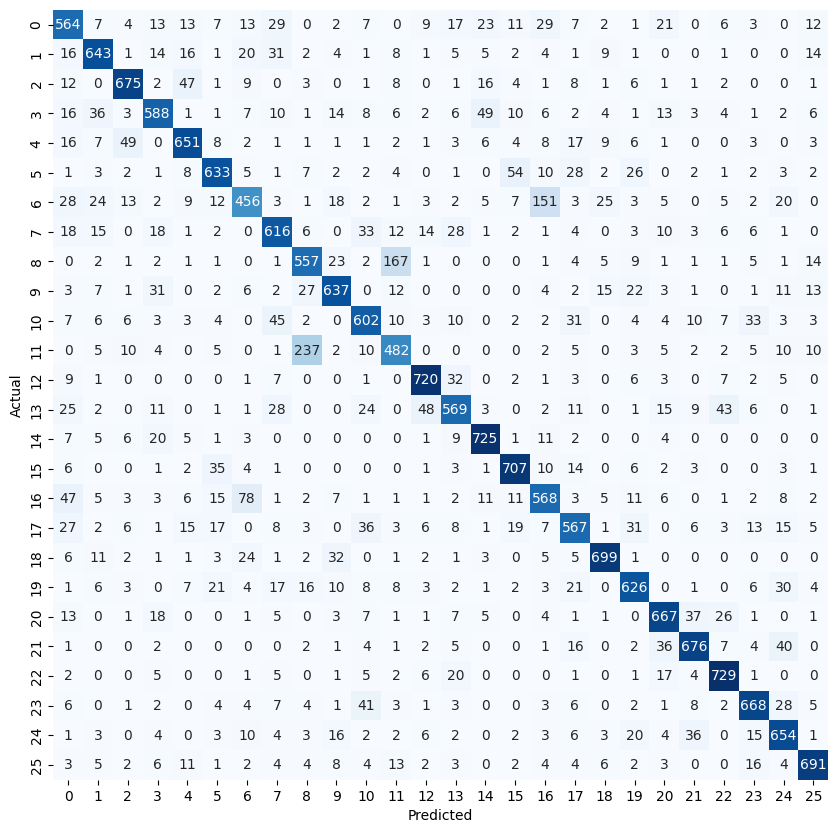

learning rate: 0.00075


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 1/50, loss: 3.2338, accuracy: 0.0645, val_loss: 3.1916, val_accuracy: 0.0947, val_f1: 0.0686


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 2/50, loss: 3.1412, accuracy: 0.1282, val_loss: 3.0794, val_accuracy: 0.1661, val_f1: 0.1349


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 3/50, loss: 2.9923, accuracy: 0.2049, val_loss: 2.8907, val_accuracy: 0.2366, val_f1: 0.1991


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 4/50, loss: 2.7577, accuracy: 0.2813, val_loss: 2.6208, val_accuracy: 0.3185, val_f1: 0.2832


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 5/50, loss: 2.4669, accuracy: 0.3457, val_loss: 2.3233, val_accuracy: 0.3718, val_f1: 0.3415


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 6/50, loss: 2.1951, accuracy: 0.3962, val_loss: 2.0922, val_accuracy: 0.4083, val_f1: 0.3877


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 7/50, loss: 1.9918, accuracy: 0.4332, val_loss: 1.9179, val_accuracy: 0.4496, val_f1: 0.4360


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 8/50, loss: 1.8431, accuracy: 0.4654, val_loss: 1.7974, val_accuracy: 0.4764, val_f1: 0.4651


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 9/50, loss: 1.7314, accuracy: 0.4900, val_loss: 1.6923, val_accuracy: 0.5015, val_f1: 0.4916


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 10/50, loss: 1.6439, accuracy: 0.5130, val_loss: 1.6265, val_accuracy: 0.5156, val_f1: 0.5067


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 11/50, loss: 1.5779, accuracy: 0.5308, val_loss: 1.5702, val_accuracy: 0.5393, val_f1: 0.5314


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 12/50, loss: 1.5227, accuracy: 0.5465, val_loss: 1.5131, val_accuracy: 0.5489, val_f1: 0.5423


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 13/50, loss: 1.4756, accuracy: 0.5581, val_loss: 1.4733, val_accuracy: 0.5620, val_f1: 0.5565


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 14/50, loss: 1.4375, accuracy: 0.5710, val_loss: 1.4315, val_accuracy: 0.5730, val_f1: 0.5674


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 15/50, loss: 1.3948, accuracy: 0.5823, val_loss: 1.3998, val_accuracy: 0.5783, val_f1: 0.5733


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 16/50, loss: 1.3601, accuracy: 0.5922, val_loss: 1.3596, val_accuracy: 0.5973, val_f1: 0.5921


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 17/50, loss: 1.3319, accuracy: 0.6006, val_loss: 1.3306, val_accuracy: 0.6065, val_f1: 0.6025


Training: 100%|██████████ [ time left: 00:00 ]


In [ ]:
lr = [0.005, 0.0025, 0.001, 0.00075]
m = 6
for lrate in lr:
    print(f"learning rate: {lrate}")
    print("===============")
    model = FNN(
        loss=CategoricalCrossEntropyLoss(),
        optimizer=SGD(learning_rate=lrate),
        learning_rate=lrate,
        layers=[
            Flatten(),
            DenseLayer(input_size, 1024, ReLU()),
            DropoutLayer(dropout_rate=0.3),
            DenseLayer(1024, 256, ReLU()),
            DropoutLayer(dropout_rate=0.2),
            DenseLayer(256, 128, ReLU()),
            DropoutLayer(dropout_rate=0.1),
            DenseLayer(128, output_size, Softmax()),
        ]
    )


    # take only part after decimal point
    lrate_str = str(lrate).split(".")[1]

    # train
    model.fit(
        X=train_ds,
        y=train_labels,
        X_val=val_ds,
        y_val=val_labels,
        epochs=50,
        batch_size=64,
        best_name=f"best{m}_{lrate_str}.pkl"
    )

    # plot
    model.plot()

    # test model
    X_test = test_ds.data
    y_test = test_ds.targets
    test_loss, test_accuracy, f1 = model.evaluate(X_test, y_test)

    print(f"test loss: {test_loss}, test accuracy: {test_accuracy}, f1: {f1}")


    # test of best model
    test_loss, test_accuracy, f1 = model.best_model_evaluate(X_test, y_test)

    print(f"best test loss: {test_loss}, test accuracy: {test_accuracy}, test f1: {f1}")

    # plot confusion matrix
    model.plot_confusion_matrix(X_test, y_test)

    # save model
    model.save(f"last{m}_{lrate_str}.pkl")